In [1]:
!pip install tensorflow opencv-python matplotlib
!pip install ffmpeg-python
!pip install opencv-python


In [2]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive
from cv2 import VideoCapture
from cv2 import waitKey
from keras.layers import Embedding


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [4]:
Model(inputs=[inputimage,verificationimage], outputs=[1,0])

NameError: name 'inputimage' is not defined

In [5]:
POS_PATH =os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', "negative")
ANC_PATH = os.path.join('data', 'anchor')


In [6]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [7]:
!tar -xf "/content/drive/MyDrive/Dev_Data/lfw.tgz"

In [8]:
for directory in os.listdir('lfw'):
  for file in os.listdir(os.path.join('lfw', directory)):
    EX_PATH = os.path.join('lfw', directory, file)
    NEW_PATH = os.path.join(NEG_PATH, file)
    os.replace(EX_PATH, NEW_PATH)

In [9]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [10]:
import uuid

In [11]:
 os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor/7bf9583e-a742-11ef-8ba1-0242ac1c000c.jpg'

In [12]:
cap = cv2.VideoCapture(4)
while cap.isOpened():
  ret, frame = cap.read()
  frame = frame[120:120+250,200:200+250, :]
  if cv2.waitKey(1) & 0XFF == ord('a'):
    imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid,uuid1()))
    cv2.imwrite(imgname, frame)
  if cv2.waitKey(1) & 0XFF == ('p'):
    imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
    cv2.imwrite(imgname, frame)
  cv2.imshow('Image Collection', frame)
  if cv2.waitKey(1) & 0XFF == ord('q'):
    break
  cap.release()
  cv2.destroyAllWindows()
  plt.imshow(frame[120:120+250,200:200+250, :])

In [15]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)


In [16]:
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'data/anchor/WIN_20241119_16_46_25_Pro.jpg'


In [17]:
def preprocess(file_path):
  byte_img = tf.io.read_file(file_path)
  img = tf.io.decode_jpeg(byte_img)
  img = tf.image.resize(img, (100,100))
  return img / 255.0

In [19]:
img=preprocess('data/anchor/WIN_20241119_16_46_25_Pro.jpg')

In [20]:
img.numpy().min()

0.007843138

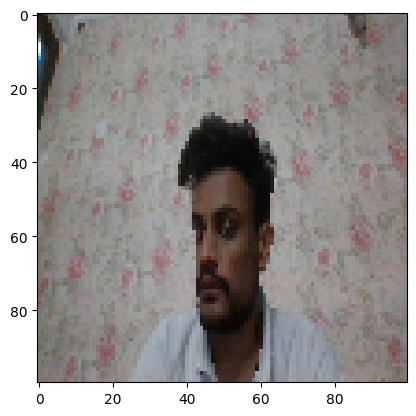

In [22]:
plt.imshow(img)

In [23]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

In [24]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [25]:
samples = data.as_numpy_iterator()

In [26]:
example = samples.next()

In [27]:
example

(b'data/anchor/WIN_20241119_16_46_25_Pro.jpg',
 b'data/positive/WIN_20241119_16_46_23_Pro.jpg',
 1.0)

In [28]:
def preprocess_twin(input_img, validation_img, label):
  return(preprocess(input_img), preprocess(validation_img), label)

In [29]:
res = preprocess_twin(*example)

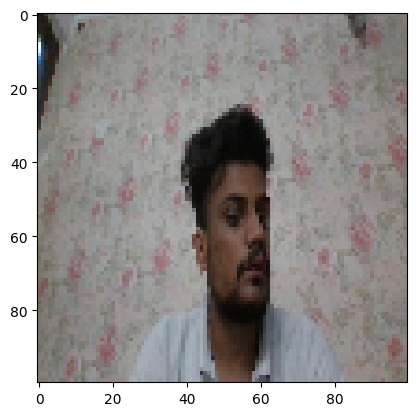

In [30]:
plt.imshow(res[1])

In [31]:
res[2]

1.0

In [32]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)


In [33]:
train_data = data.take(round(len(data)*7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)


In [34]:
test_data = data.skip(round(len(data)*7))
test_data = test_data.take(round(len(data)*3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [35]:
inp = Input(shape=(100,100,3), name='input_image')

In [36]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)


In [37]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [38]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [39]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)


In [40]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [41]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [42]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
def make_embedding():
  inp = Input(shape=(100,100,3), name='input_image')
  c1 = Conv2D(64, (10,10), activation='relu')(inp)
  m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
  c2 = Conv2D(128, (7,7), activation='relu')(m1)
  m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
  c3 = Conv2D(128, (4,4), activation='relu')(m2)
  m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
  c4 = Conv2D(256, (4,4), activation='relu')(m3)
  f1 = Flatten()(c4)
  d1 = Dense(4096, activation='sigmoid')(f1)
  return Model(inputs=[inp], outputs=[d1], name='embedding')

In [44]:
embedding = make_embedding()

In [45]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
class L1Dist(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
  def call(self, input_embedding, validation_embedding):
    input_embedding = tf.convert_to_tensor(input_embedding)
    validation_embedding = tf.convert_to_tensor(validation_embedding)
    return tf.math.abs(input_embedding - validation_embedding)

In [47]:
l1 = L1Dist()

In [48]:
l1

<L1Dist name=l1_dist, built=False>

In [49]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

In [50]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))


In [51]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [52]:
siamese_layer = L1Dist()

In [53]:
distances = siamese_layer(inp_embedding, val_embedding)

In [54]:
classifier = Dense(1, activation='sigmoid')(distances)

In [55]:
classifier

<KerasTensor shape=(1, None, 1), dtype=float32, sparse=False, name=keras_tensor_21>

In [56]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [57]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)    │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ validation_img            │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Functional)    │ (None, 4096)           │     38,960,448 │ input_img[0][0],       │
│                           │                        │                │ validation_img[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l1_dist_1 (L1Dist)        │ (1, None, 4096)        │              0 │ embedding[0][0],       │
│                           │                        │                │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (1, None, 1)           │          4,097 │ l1_dist_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
def make_siamese_model():
  input_image = Input(name='input_image', shape=(100,100,3))
  validation_image = Input(name='validation_image', shape=(100,100,3))
  siamese_layer = L1Dist()
  siamese_layer._name = 'distance'
  distances = siamese_layer(embedding(input_image), embedding(validation_image))
  classifier = Dense(1, activation='sigmoid')(distances)
  return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [59]:
siamese_model = make_siamese_model()

In [60]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ validation_image          │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Functional)    │ (None, 4096)           │     38,960,448 │ input_image[0][0],     │
│                           │                        │                │ validation_image[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l1_dist_2 (L1Dist)        │ (1, None, 4096)        │              0 │ embedding[2][0],       │
│                           │                        │                │ embedding[3][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (1, None, 1)           │          4,097 │ l1_dist_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [62]:
opt = tf.keras.optimizers.Adam(1e-4)

In [63]:
checkpoint_dir = '/content/data/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [64]:
test_batch = train_data.as_numpy_iterator()

In [65]:
batch_1 = test_batch.next()

In [66]:
X = batch_1[:2]

In [67]:
y = batch_1[2]

In [68]:
y

array([0., 1., 1., 0.], dtype=float32)

In [69]:
tf.losses.BinaryCrossentropy??

In [97]:
@tf.function
def train_step(batch):
  with tf.GradientTape() as tape:
    X = batch[:2]
    y = batch[2]
    yhat = siamese_model(X, training=True)
    y = tf.reshape(y, (-1, 1))
    yhat = tf.reshape(yhat, (-1, 1))
    loss = binary_cross_loss(y, yhat)
  print(loss)
  grad = tape.gradient(loss, siamese_model.trainable_variables)
  opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
  return loss

In [98]:
def train(data, EPOCHS):
  for epoch in range(1, EPOCHS+1):
    print('\n EPOCH {}/{}'.format(epoch, EPOCHS))
    progbar = tf.keras.utils.Progbar(len(data))
    for idx, batch in enumerate(data):
      train_step(batch)
      progbar.update(idx+1)
    if epoch % 10==0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [139]:
EPOCH = 50

In [100]:
train(train_data, EPOCH)


 EPOCH 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step

 EPOCH 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step

 EPOCH 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step

 EPOCH 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step

 EPOCH 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step

 EPOCH 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step

 EPOCH 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step

 EPOCH 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step

 EPOCH 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step

 EPOCH 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step

 EPOCH 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step

 EPOCH 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step

 EPOCH 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step

 EPOCH 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step

 EPOCH 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step

 EPOCH 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step

 EPOCH 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/

In [131]:
from tensorflow.keras.metrics import Precision, Recall

In [169]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

AttributeError: 'NumpyIterator' object has no attribute 'as_numpy_iterator'

In [170]:
y_hat = siamese_model.predict([test_input, test_val])

NameError: name 'test_input' is not defined

In [171]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

NameError: name 'y_hat' is not defined

In [172]:
y_true

NameError: name 'y_true' is not defined

In [173]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

NameError: name 'y_true' is not defined

In [174]:
m = Precision()
m.update_state(y_true, y_hat)
m.result().numpy()

NameError: name 'y_true' is not defined

In [175]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat)

print(r.result().numpy(), p.result().numpy())

AttributeError: 'NumpyIterator' object has no attribute 'as_numpy_iterator'

NameError: name 'test_input' is not defined

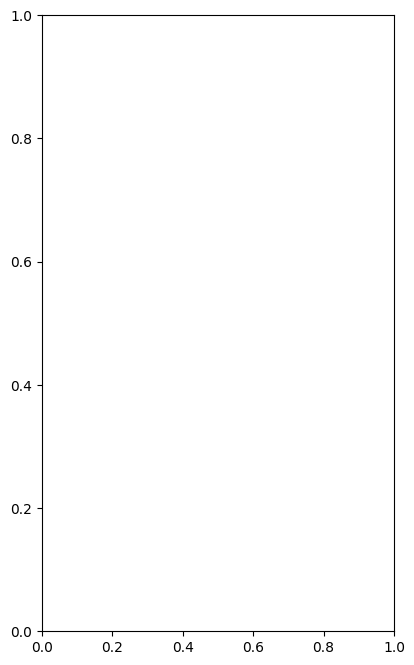

In [176]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.show()

In [177]:
siamese_model.save('siamesemodelv2.h5')

In [178]:
L1Dist

__main__.L1Dist

In [179]:

siamese_model = tf.keras.models.load_model('siamesemodelv2.h5',
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [180]:
siamese_model.predict([test_input, test_val])

NameError: name 'test_input' is not defined

In [181]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ validation_image          │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Functional)    │ (None, 4096)           │     38,960,448 │ input_image[0][0],     │
│                           │                        │                │ validation_image[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l1_dist_3 (L1Dist)        │ (1, None, 4096)        │              0 │ embedding[0][0],       │
│                           │                        │                │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (1, None, 1)           │          4,097 │ l1_dist_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [183]:
application_data\verification_images

SyntaxError: unexpected character after line continuation character (<ipython-input-183-10b5f818160f>, line 1)

In [184]:
os.listdir(os.path.join('application_data', 'verification_images'))

FileNotFoundError: [Errno 2] No such file or directory: 'application_data/verification_images'

In [185]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [186]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

FileNotFoundError: [Errno 2] No such file or directory: 'application_data/verification_images'

In [187]:
def verify(model, detection_threshold, verification_threshold):def verify(model, detection_threshold, verification_threshold):
  results = []
  for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
  detection = np.sum(np.array(results) > detection_threshold)
  verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
  verified = verification > verification_threshold

  return results, verified

SyntaxError: invalid syntax (<ipython-input-187-d74ac2601080>, line 1)

In [189]:
cap = cv2.VideoCapture(4)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]

    cv2.imshow('Verification', frame)

    if cv2.waitKey(10) & 0xFF == ord('v'):
      cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
      results, verified = verify(siamese_model, 0.5, 0.5)
      print(verified)
     if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 12)

In [190]:
np.sum(np.squeeze(results) > 0.9)

NameError: name 'results' is not defined

In [191]:
results

NameError: name 'results' is not defined